In [2]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
# Rasterstats contains the zonalstatistics function that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1.5)

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Download tutorial data
data = et.data.get_data("spatial-vector-lidar")


Extracted output to C:\Users\emack\earth-analytics\data\spatial-vector-lidar\.


# Import Canopy Height Model

First,  import a canopy height model created by the National Ecological Observatory Network (NEON). In the previous lessons / weeks you learned how to make a canopy height model by subtracting the Digital elevation model (DEM) from the Digital surface model (DSM).

# Context Managers and Rasterio

Use a context manager with to create a connection to your raster dataset. This connection will be automatically closed at the end of the with statement.

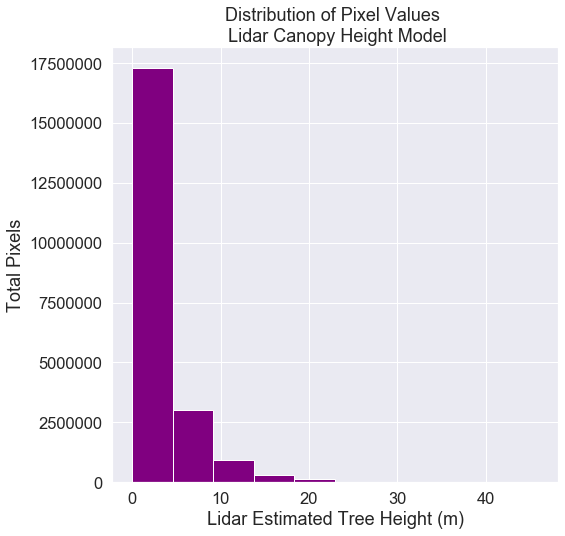

In [3]:
# Load & plot the data
with rio.open('data/spatial-vector-lidar/california/neon-sjer-site/2013/lidar/SJER_lidarCHM.tif') as sjer_lidar_chm_src:
    SJER_chm_data = sjer_lidar_chm_src.read(1, masked=True)
    sjer_chm_meta = sjer_lidar_chm_src.profile

fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(SJER_chm_data.ravel(),
        color="purple")
ax.set(xlabel="Lidar Estimated Tree Height (m)",
       ylabel="Total Pixels",
       title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax.ticklabel_format(useOffset=False,
                    style='plain')


### Bar plot showing the distribution of lidar canopy height model pixel values

# Clean Up Data - Remove 0’s

Looking at the distribution of data, you can see there are many pixels that have a value of 0 - where there are no trees. Also, using the NEON data, values below 2m are normally set to 0 given the accuracy of the lidar instrument used to collect these data.

Set all pixel values ==0 to nan as they will impact calculation of plot mean height. A mean calculated with values of 0 will be significantly lower than a mean calculated with just tree height values.

In [6]:
# Set CHM values of 0 to NAN (no data or not a number)
SJER_chm_data[SJER_chm_data == 0] = np.nan

# View summary statistics of canopy height model
print('Mean:', np.nanmean(SJER_chm_data))
print('Max:', np.nanmax(SJER_chm_data))
print('Min:', np.nanmin(SJER_chm_data))

Mean: 8.213505
Max: 45.879997
Min: 2.0


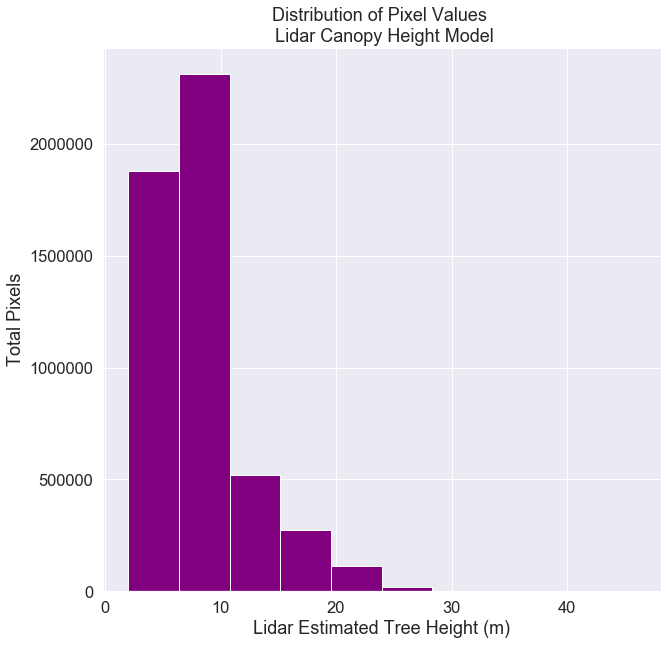

In [7]:
# Remove nans, flatten the data & plot historgram
SJER_chm_data_no_na = SJER_chm_data[~np.isnan(SJER_chm_data)].ravel()

fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(SJER_chm_data_no_na, color="purple")
ax.set(xlabel='Lidar Estimated Tree Height (m)', ylabel='Total Pixels',
       title='Distribution of Pixel Values \n Lidar Canopy Height Model')

ax.ticklabel_format(useOffset=False,
                    style='plain')


### Bar plot showing the distribution of lidar chm values with 0's removed

# Import Plot Location Data & Create Buffer

You now have a cleaned canopy height model for your study area in California. However, how do the height values extracted from the CHM compare to our manually collected, field measured canopy height data? To figure this out, you will use in situ collected tree height data, measured within circular plots across our study area. You will compare the maximum measured tree height value to the maximum LiDAR derived height value for each circular plot using regression.

In [8]:
sjer_centroids_path = 'data/spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_plot_centroids.shp'
SJER_plots_points = gpd.read_file(sjer_centroids_path)
type(SJER_plots_points)


geopandas.geodataframe.GeoDataFrame

In [9]:
# Ensure this is a points layer as you think it is
SJER_plots_points.geom_type.head()


0    Point
1    Point
2    Point
3    Point
4    Point
dtype: object

# Overlay Points on Top Of Your Raster Data

Finally, a quick plot allows you to check that your points actually overlay on top of the canopy height model. This is a good sanity check just to ensure your data actually line up and are for the same location.

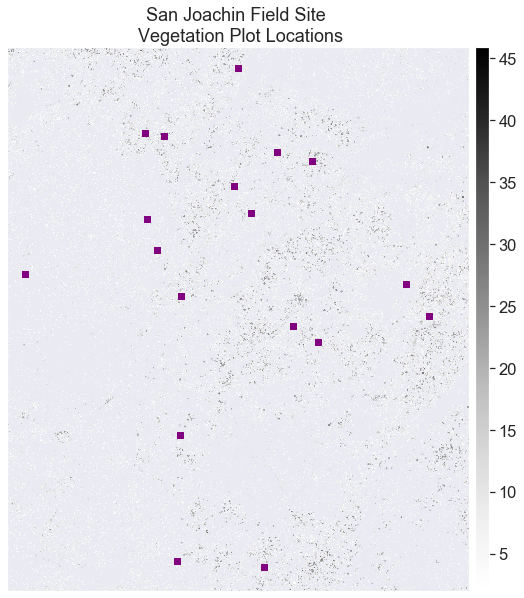

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ep.plot_bands(SJER_chm_data,
              # Here you must set the spatial extent or else the data will not line up with your geopandas layer
              extent=plotting_extent(sjer_lidar_chm_src),
              cmap='Greys',
              title="San Joachin Field Site \n Vegetation Plot Locations",
              scale=False,
              ax=ax)
SJER_plots_points.plot(ax=ax,
                       marker='s',
                       markersize=45,
                       color='purple')